In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import rcParams
import math
from utils.utils import *
from dtw import dtw
np.random.seed(2)

In [3]:
# Set device
print(f'The device used in this notebook is: {setDevice()}')

DEVICE = setDevice()

The device used in this notebook is: cuda


#### Import data

In [4]:
# Set settings
features, input_window, output_window, stride = set_settings()

print(f'features: {features}')
print(f'input_window: {input_window}')
print(f'output_window: {output_window}')
print(f'stride: {stride}')

features: ['Hips Flexion-Extension Left', 'Knees Flexion-Extension Left', 'Ankles Dorsiflexion-Plantarflexion Left', 'Hips Flexion-Extension Right', 'Knees Flexion-Extension Right', 'Ankles Dorsiflexion-Plantarflexion Right']
input_window: 100
output_window: 1
stride: 1


In [5]:
file_dir = r'D:\Study 2 Data\Healthy Gait\Train_Val' 
# file_dir = r'D:\Study 2 Data\CP Gait\Train'
train_files = os.listdir(file_dir) 

# Changes the working directory to get the data from their location 
os.chdir(file_dir)
cwd = os.getcwd()

print(f'Current working directory is: {cwd}')
print(f"There are {len(train_files)} files in the specified path.")

Current working directory is: D:\Study 2 Data\Healthy Gait\Train_Val
There are 9 files in the specified path.


In [6]:
train_files

['AB2188 BF T1-5.csv',
 'AB3154 BF T6-10.csv',
 'AB6751 BF T1-5.csv',
 'AB7422 BF T1-5.csv',
 'AB7779 BF T1-5.csv',
 'AB9119 BF T1-5.csv',
 'AB9737 BF T1-5.csv',
 'AB9737 BF T6-10.csv',
 'AB9738 BF T1-5.csv']

In [7]:

#Create feature list to extract values needed from CSV files
all_features = ['Trial', 'Time'] + features
all_features


['Trial',
 'Time',
 'Hips Flexion-Extension Left',
 'Knees Flexion-Extension Left',
 'Ankles Dorsiflexion-Plantarflexion Left',
 'Hips Flexion-Extension Right',
 'Knees Flexion-Extension Right',
 'Ankles Dorsiflexion-Plantarflexion Right']

In [8]:
all_data = create_dataframe(train_files, all_features)

Extracting data from: AB2188 BF T1-5.csv
Extracting data from: AB3154 BF T6-10.csv
Extracting data from: AB6751 BF T1-5.csv
Extracting data from: AB7422 BF T1-5.csv
Extracting data from: AB7779 BF T1-5.csv
Extracting data from: AB9119 BF T1-5.csv
Extracting data from: AB9737 BF T1-5.csv
Extracting data from: AB9737 BF T6-10.csv
Extracting data from: AB9738 BF T1-5.csv


In [9]:


all_data.reset_index(drop=True, inplace=True) #reset the index of the table
# path = r'D:\Study 2 Data\Healthy Gait' + '\\' + 'all_data_healthy_train.csv'
# all_data.to_csv(path)

In [10]:
all_data

,Patient ID,Trial,Time,Hips Flexion-Extension Left,Knees Flexion-Extension Left,Ankles Dorsiflexion-Plantarflexion Left,Hips Flexion-Extension Right,Knees Flexion-Extension Right,Ankles Dorsiflexion-Plantarflexion Right
0,AB2188 BF T1-5,1,223.83,24.69730,43.98116,13.16722,7.40105,19.83552,3.46198
1,AB2188 BF T1-5,1,223.84,24.44713,43.17039,13.07729,7.04358,19.57988,3.53245
2,AB2188 BF T1-5,1,223.85,24.17547,42.45852,13.01625,6.69202,19.29897,3.58736
3,AB2188 BF T1-5,1,223.86,23.88122,41.82635,12.98980,6.35465,19.00309,3.63057
4,AB2188 BF T1-5,1,223.87,23.56337,41.25273,13.00300,6.03926,18.70273,3.66602
...,...,...,...,...,...,...,...,...,...
85147,AB9738 BF T1-5,10,357.98,10.99086,7.10503,6.93556,24.15779,24.79361,-6.96295
85148,AB9738 BF T1-5,10,357.99,10.66388,6.95092,7.04563,23.36649,23.37365,-6.78526
85149,AB9738 BF T1-5,10,358.00,10.47453,6.99232,7.14855,22.59988,22.00132,-6.50384
85150,AB9738 BF T1-5,10,358.01,10.44759,7.27248,7.23479,21.89250,20.71157,-6.14128


In [11]:
n_trials = all_data['Trial'].max()
print(f'maximum number of trials is: {n_trials}')

maximum number of trials is: 16


In [12]:
all_data['Patient ID'].unique()

array(['AB2188 BF T1-5', 'AB3154 BF T6-10', 'AB6751 BF T1-5',
       'AB7422 BF T1-5', 'AB7779 BF T1-5', 'AB9119 BF T1-5',
       'AB9737 BF T1-5', 'AB9737 BF T6-10', 'AB9738 BF T1-5'],
      dtype=object)

In [13]:
# Healthy Subjects 
train_subjects = ['AB2188 BF T1-5',
                    'AB3154 BF T6-10', 
                    'AB6751 BF T1-5',
                    'AB7422 BF T1-5',
                    'AB7779 BF T1-5', 
                    'AB9737 BF T1-5', 
                    'AB9737 BF T6-10', 
                    'AB9119 BF T1-5',]

val_subjects = ['AB9738 BF T1-5']

In [14]:
val_subjects

['AB9738 BF T1-5']

In [15]:
train_data = all_data.loc[all_data['Patient ID'].isin(train_subjects)]

val_data = all_data.loc[all_data['Patient ID'].isin(val_subjects)]

In [16]:
print(f'all_data: {all_data.shape}')
print(f'train_data: {train_data.shape}')
print(f'val_data: {val_data.shape}')

all_data: (85152, 9)
train_data: (76720, 9)
val_data: (8432, 9)


In [17]:
train_samples = count_nsamples(train_data)
val_samples = count_nsamples(val_data)

For patient: AB2188 BF T1-5, trial: 1, there are: 718 time-points
For patient: AB2188 BF T1-5, trial: 2, there are: 801 time-points
For patient: AB2188 BF T1-5, trial: 3, there are: 706 time-points
For patient: AB2188 BF T1-5, trial: 4, there are: 651 time-points
For patient: AB2188 BF T1-5, trial: 5, there are: 741 time-points
For patient: AB2188 BF T1-5, trial: 6, there are: 691 time-points
For patient: AB2188 BF T1-5, trial: 7, there are: 722 time-points
For patient: AB2188 BF T1-5, trial: 8, there are: 726 time-points
For patient: AB2188 BF T1-5, trial: 9, there are: 740 time-points
For patient: AB2188 BF T1-5, trial: 10, there are: 766 time-points
For patient: AB3154 BF T6-10, trial: 1, there are: 651 time-points
For patient: AB3154 BF T6-10, trial: 2, there are: 541 time-points
For patient: AB3154 BF T6-10, trial: 3, there are: 613 time-points
For patient: AB3154 BF T6-10, trial: 4, there are: 601 time-points
For patient: AB3154 BF T6-10, trial: 5, there are: 711 time-points
For 

In [18]:
print(f'Number of train samples: {train_samples}')
print(f'Number of validation samples: {val_samples}')

Number of train samples: 89
Number of validation samples: 9


In [19]:
m = all_data['Patient ID'].unique()

In [20]:

def pd_to_np_converter(data, n_samples, features):
    #create a numpy array that stores the data for export
    sample_ID = []
    # patients = 2
    # n_trials = 10
    # # samples = patients * n_trials
    data_store = np.zeros((n_samples, 2000, len(features)), dtype=np.float32)
    i = 0

    for p in data['Patient ID'].unique(): #loop over patients 
        for t in data['Trial'].unique(): #loop over trials starting with trials 1 to trial 9 (inclusive)
            pd_array = data[(data['Patient ID'] == p) & (data['Trial'] == t)]
            if pd_array.empty:
                continue
                # print('DataFrame is empty!')
                # print(f'Trail {t} does not exist in {p}')
            else:
                np_array = pd_array.to_numpy()
                data_store[i, :np_array.shape[0], :] = np_array[:,3:] 
                sample_ID.append(p+ ' Ts'+str(t)) 
                i +=1

    return pd_array.columns, data_store


In [21]:
train_columns, train_data_np = pd_to_np_converter(train_data, train_samples, features)
val_columns, val_data_np = pd_to_np_converter(val_data, val_samples, features)

print(f'train_data_np.shape: {train_data_np.shape}')
print(f'val_data_np.shape: {val_data_np.shape}')

train_data_np.shape: (89, 2000, 6)
val_data_np.shape: (9, 2000, 6)


In [22]:
train_columns[3:].tolist() 

['Hips Flexion-Extension Left',
 'Knees Flexion-Extension Left',
 'Ankles Dorsiflexion-Plantarflexion Left',
 'Hips Flexion-Extension Right',
 'Knees Flexion-Extension Right',
 'Ankles Dorsiflexion-Plantarflexion Right']

In [23]:
features == train_columns[3:].tolist() 

True

In [24]:
labels_keys = train_columns[3:].tolist() #copy the train columns removing the first column headers'Patient ID', 'Trial', 'Time'


if features == labels_keys: # check that the features are the same as the label keys 
    print('YAY! Column headers of dataframe match features')
else:
    print('ERROR: Features and labels_keys do not match!')

YAY! Column headers of dataframe match features


In [25]:
labels_keys = features 

labels_idx = np.arange(0, len(labels_keys), 1)

labels = dict(zip(labels_keys, labels_idx))

len(labels)
labels
# labels_keys

{'Hips Flexion-Extension Left': 0,
 'Knees Flexion-Extension Left': 1,
 'Ankles Dorsiflexion-Plantarflexion Left': 2,
 'Hips Flexion-Extension Right': 3,
 'Knees Flexion-Extension Right': 4,
 'Ankles Dorsiflexion-Plantarflexion Right': 5}

In [26]:
def window_generator_fltrd(sequence, input_window, output_window, stride, features, labels):
    """
    Trims the input sequence from leading and trailing zeros, then generates an array with input windows and another array for the corresponding output windows
    Args:
        sequence: (np.array, float32) columns are features while rows are time points
        features: (list, strin~g) column names
        input_window: (int)
        stride (int): the value the input window shifts along the sequence 
    Returns:

    """
    # shortest_seqLen = float('inf')

    # f_zeros = [] #array that stores the number of leading zeros for each feature
    b_zeros = [] #array that stores the number of trailing zeros for each feacture 

    for f in features:
        # trim the leading and training zeros
        # f_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'f').shape[0]) #forward zeros
        b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros

    # max_f_zeros = max(f_zeros) #find the maximum number of leading zeros
    max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 
    # print(max_b_zeros)

    #total sequence length minus max leading and trailing zeros 
    trimmed_seqLen = sequence[:,0].shape[0] - (max_b_zeros)
    trimmed_seqLen_reduced = trimmed_seqLen - 200 #reducing sequence size to remove the first and last 200 timesteps which may contain errors   
    print(f'trimmed_seqLen: {trimmed_seqLen}')
    print(f'trimmed_seqLen_reduced: {trimmed_seqLen_reduced}')


    # Slides are the number of times the input window can scan the sequence 
    # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
    # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
    slides = ((trimmed_seqLen_reduced - (input_window+output_window)) // stride) + 1
    print(f"number of slides is: {slides}")

    # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
    seq_indicies = (np.arange(slides) * stride) + 100

    if slides <= 0:
        raise ValueError("input window and output window length are greater than sequence length, check their values")

    # Creates an zero numpy array to store the samples in 
    X_values = np.zeros((len(seq_indicies) , input_window, len(features)))
    Y_values = np.zeros((len(seq_indicies), output_window, len(features)))

    # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
    for j, feature in enumerate(features):
        # print(j)
        # print(feature)
        for i, idx in enumerate(seq_indicies):
            X_values[i, :, j] = sequence[idx:idx+input_window, labels[feature]]
            Y_values[i, :, j] = sequence[idx+input_window:idx+input_window + output_window, labels[feature]]

    return X_values, Y_values 

In [27]:
def window_generator_lt_fltrd(sequence, input_window, future_window, stride, features, labels): #window gernerator long term fltrd (creats a validation window up to 200 timesteps in advance to measure error on long term future predictions)
    """
    Trims the input sequence from leading and trailing zeros, then generates an array with input windows and another array for the corresponding output windows
    Args:
        sequence: (np.array, float32) columns are features while rows are time points
        features: (list, strin~g) column names
        input_window: (int)
        stride (int): the value the input window shifts along the sequence 
    Returns:

    """
    b_zeros = [] #array that stores the number of trailing zeros for each feacture 

    for f in features:
        # trim the leading and training zeros
        b_zeros.append(sequence[:,labels[f]].shape[0] - np.trim_zeros(sequence[:,labels[f]], 'b').shape[0]) #backward zeros

    max_b_zeros = max(b_zeros) #find the maximum number of trailing/backward zeros 
    # print(max_b_zeros)

    fltrd_samples = 2 * 150 #remove 150 timesteps from the beggining and ending of the entire sequence
    # lt_len = 200 # number of timesteps to predict in the future based on a single input window (to be used in measuring errors based on prediction input)
    
    #total sequence length minus max leading and trailing zeros 
    trimmed_seqLen = sequence[:,0].shape[0] - (max_b_zeros)
    trimmed_seqLen_reduced = trimmed_seqLen - (fltrd_samples) # (- fltrd_samples is done to reduce sequence size to remove the first and last 150 timesteps which may contain errors since they corresponding to beggining and ending of the trials 
    print(f'trimmed_seqLen: {trimmed_seqLen}')
    print(f'trimmed_seqLen_reduced: {trimmed_seqLen_reduced}')


    # Slides are the number of times the input window can scan the sequence 
    # Using the equation that calculates the number of outputs as in convolution  (W – F + 2P) / S + 1, W=input image width, F=filter width, P=padding, S=stride
    # The width of the image is taken as the number of time steps in the sequence, corresponding to the length of any TRIMMED column in the data 
    slides = ((trimmed_seqLen_reduced - (input_window+future_window)) // stride) + 1
    print(f"number of slides is: {slides}")

    # Calculating the first index of each of the output sequences (first index always f_zeros as its always shifted to start with the first non-zero element)
    seq_indicies = (np.arange(slides) * stride) + 150

    if slides <= 0:
        raise ValueError("input window and output window length are greater than sequence length, check their values")
        # return None 

    # Creates an zero numpy array to store the samples in 
    X_values = np.zeros((len(seq_indicies) , input_window, len(features)))
    Y_values = np.zeros((len(seq_indicies), future_window, len(features)))

    # Loop through the features, then loop through the list of sequence indicies needed for input and output windows 
    for j, feature in enumerate(features):
        # print(j)
        # print(feature)
        for i, idx in enumerate(seq_indicies):
            X_values[i, :, j] = sequence[idx:idx+input_window, labels[feature]]
            Y_values[i, :, j] = sequence[idx+input_window:idx+input_window + future_window, labels[feature]]

    return X_values, Y_values 

In [28]:
# Creating training datasets
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 900


# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_train_windows = np.zeros((samples_per_file*train_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_train_windows = np.zeros((samples_per_file*train_samples, output_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
train_sample_sum = 0
train_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(train_samples): 
       
    X_values, Y_values = window_generator_fltrd(
        train_data_np[i,:,:],
        input_window=input_window, 
        output_window=output_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_train_windows[start_idx:end_idx, :, :] = X_values
    Y_train_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    train_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_train_data = X_train_windows[:end_idx, :, :].astype('float64')
Y_train_data = Y_train_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_train_windows: {X_train_windows.shape}')
print(f'shape of Y_train_windows: {Y_train_windows.shape}')

print(f'shape of X_train_data: {X_train_data.shape}')
print(f'shape of Y_train_data: {Y_train_data.shape}')

trimmed_seqLen: 718
trimmed_seqLen_reduced: 518
number of slides is: 418
trimmed_seqLen: 801
trimmed_seqLen_reduced: 601
number of slides is: 501
trimmed_seqLen: 706
trimmed_seqLen_reduced: 506
number of slides is: 406
trimmed_seqLen: 651
trimmed_seqLen_reduced: 451
number of slides is: 351
trimmed_seqLen: 741
trimmed_seqLen_reduced: 541
number of slides is: 441
trimmed_seqLen: 691
trimmed_seqLen_reduced: 491
number of slides is: 391
trimmed_seqLen: 722
trimmed_seqLen_reduced: 522
number of slides is: 422
trimmed_seqLen: 726
trimmed_seqLen_reduced: 526
number of slides is: 426
trimmed_seqLen: 740
trimmed_seqLen_reduced: 540
number of slides is: 440
trimmed_seqLen: 766
trimmed_seqLen_reduced: 566
number of slides is: 466
trimmed_seqLen: 651
trimmed_seqLen_reduced: 451
number of slides is: 351
trimmed_seqLen: 541
trimmed_seqLen_reduced: 341
number of slides is: 241
trimmed_seqLen: 613
trimmed_seqLen_reduced: 413
number of slides is: 313
trimmed_seqLen: 601
trimmed_seqLen_reduced: 401
num

In [29]:
# Creating validation datasets
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 1600


# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_val_windows = np.zeros((samples_per_file*val_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_val_windows = np.zeros((samples_per_file*val_samples, output_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
val_sample_sum = 0
val_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(val_samples): 
       
    X_values, Y_values = window_generator_fltrd(
        val_data_np[i,:,:],
        input_window=input_window, 
        output_window=output_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_val_windows[start_idx:end_idx, :, :] = X_values
    Y_val_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    val_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_val_data = X_val_windows[:end_idx, :, :].astype('float64')
Y_val_data = Y_val_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_val_windows: {X_val_windows.shape}')
print(f'shape of Y_val_windows: {Y_val_windows.shape}')

print(f'shape of X_val_data: {X_val_data.shape}')
print(f'shape of Y_val_data: {Y_val_data.shape}')

trimmed_seqLen: 896
trimmed_seqLen_reduced: 696
number of slides is: 596
trimmed_seqLen: 981
trimmed_seqLen_reduced: 781
number of slides is: 681
trimmed_seqLen: 1001
trimmed_seqLen_reduced: 801
number of slides is: 701
trimmed_seqLen: 906
trimmed_seqLen_reduced: 706
number of slides is: 606
trimmed_seqLen: 958
trimmed_seqLen_reduced: 758
number of slides is: 658
trimmed_seqLen: 951
trimmed_seqLen_reduced: 751
number of slides is: 651
trimmed_seqLen: 904
trimmed_seqLen_reduced: 704
number of slides is: 604
trimmed_seqLen: 926
trimmed_seqLen_reduced: 726
number of slides is: 626
trimmed_seqLen: 909
trimmed_seqLen_reduced: 709
number of slides is: 609
shape of X_val_windows: (14400, 100, 6)
shape of Y_val_windows: (14400, 1, 6)
shape of X_val_data: (5732, 100, 6)
shape of Y_val_data: (5732, 1, 6)


In [30]:
# Creating validation datasets (long term predictions)
# Selecting the features to be used when creating windows 
approx_seq_len = 2000 # appoximate the length of the longest sequence that can be encountered 
# samples_per_file = ((approx_seq_len - (input_window+output_window)) // stride) + 1 #number of window samples generated per file 
samples_per_file = 1600

future_window = 200

# create a zero-filled 3D array with shape (number of samples * number of files, window size, number of features)
X_val_lt_windows = np.zeros((samples_per_file*val_samples, input_window, len(features)), dtype=np.float32) #size can be reduced by decreasing train_size 
Y_val_lt_windows = np.zeros((samples_per_file*val_samples, future_window, len(features)), dtype=np.float32) 


start_idx = 0 #setting start index to equal zero 
val_lt_sample_sum = 0
val_lt_excluded_samples = []
# Create training windows 

#for i in tqdm(range(train_size)): #Use for including all data including outliers 
for i in range(val_samples): 
       
    X_values, Y_values = window_generator_lt_fltrd(
        val_data_np[i,:,:],
        input_window=input_window, 
        future_window=future_window, 
        stride=stride, 
        features=features,
        labels=labels
        )

    end_idx = start_idx + X_values.shape[0]

    # print(f'file number [{f}] start index: {start_idx}, end index: {end_idx}, number of samples: {X_values.shape[0]}')

    X_val_lt_windows[start_idx:end_idx, :, :] = X_values
    Y_val_lt_windows[start_idx:end_idx, :, :] = Y_values

    # print(f'number of samples copied: {X_train_data_store[start_idx:end_idx, :, :].shape[0]}')

    start_idx = end_idx 
    val_lt_sample_sum += X_values.shape[0]

    # except Exception:
    #     exception_msg(i)
    #     train_excluded_samples.append(i)

# print(f"Completed storage of training windows samples, which contains {X_train_data_store.shape[0]} samples")
X_val_lt_data = X_val_lt_windows[:end_idx, :, :].astype('float64')
Y_val_lt_data = Y_val_lt_windows[:end_idx, :, :].astype('float64')


print(f'shape of X_val_lt_windows: {X_val_lt_windows.shape}')
print(f'shape of Y_val_lt_windows: {Y_val_lt_windows.shape}')

print(f'shape of X_val_lt_data: {X_val_lt_data.shape}')
print(f'shape of Y_val_lt_data: {Y_val_lt_data.shape}')

trimmed_seqLen: 896
trimmed_seqLen_reduced: 596
number of slides is: 297
trimmed_seqLen: 981
trimmed_seqLen_reduced: 681
number of slides is: 382
trimmed_seqLen: 1001
trimmed_seqLen_reduced: 701
number of slides is: 402
trimmed_seqLen: 906
trimmed_seqLen_reduced: 606
number of slides is: 307
trimmed_seqLen: 958
trimmed_seqLen_reduced: 658
number of slides is: 359
trimmed_seqLen: 951
trimmed_seqLen_reduced: 651
number of slides is: 352
trimmed_seqLen: 904
trimmed_seqLen_reduced: 604
number of slides is: 305
trimmed_seqLen: 926
trimmed_seqLen_reduced: 626
number of slides is: 327
trimmed_seqLen: 909
trimmed_seqLen_reduced: 609
number of slides is: 310
shape of X_val_lt_windows: (14400, 100, 6)
shape of Y_val_lt_windows: (14400, 200, 6)
shape of X_val_lt_data: (3041, 100, 6)
shape of Y_val_lt_data: (3041, 200, 6)


In [31]:
scalars= np.array([[-45., -45., -90., -45., -45., -90.], [100., 120., 45., 100., 120., 45.]])


In [32]:
# X_train_norm, scalars = normalise_fit(X_train_data)
X_train_norm = normalise_transform(X_train_data, scalars)

Y_train_norm = normalise_transform(Y_train_data, scalars)

X_val_norm = normalise_transform(X_val_data, scalars)
Y_val_norm = normalise_transform(Y_val_data, scalars)

X_val_lt_norm = normalise_transform(X_val_lt_data, scalars)
Y_val_lt_norm = normalise_transform(Y_val_lt_data, scalars)


scalars

array([[-45., -45., -90., -45., -45., -90.],
       [100., 120.,  45., 100., 120.,  45.]])

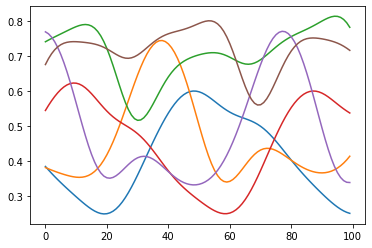

In [33]:
plt.plot(X_train_norm[2089,:])

In [34]:
# Convert to Tensor 
# do not store on GPU (yet)
X_train = torch.from_numpy(X_train_norm).to(torch.float64)
Y_train = torch.from_numpy(Y_train_norm).to(torch.float64)

# X_val = torch.from_numpy(X_val_norm).float()

# X_val_resized = np.expand_dims(Y_val_norm[:,0,:], axis=1)
# Y_val = torch.from_numpy(X_val_resized).float()

X_val = torch.from_numpy(X_val_norm).to(torch.float64)
Y_val = torch.from_numpy(Y_val_norm).to(torch.float64)


X_val_lt = torch.from_numpy(X_val_lt_norm).to(torch.float64)
Y_val_lt = torch.from_numpy(Y_val_lt_norm).to(torch.float64)


print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

print(f'X_val shape: {X_val.shape}')
print(f'Y_val shape: {Y_val.shape}')

print(f'X_val_lt shape: {X_val_lt.shape}') #long term predictions
print(f'Y_val_lt shape: {Y_val_lt.shape}') #long term predictions




X_train shape: torch.Size([50020, 100, 6])
Y_train shape: torch.Size([50020, 1, 6])
X_val shape: torch.Size([5732, 100, 6])
Y_val shape: torch.Size([5732, 1, 6])
X_val_lt shape: torch.Size([3041, 100, 6])
Y_val_lt shape: torch.Size([3041, 200, 6])


In [35]:
X_val.dtype

torch.float64

In [36]:
train_dataset = gaitDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle = True)
# train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle = False) #256

val_dataset = gaitDataset(X_val, Y_val) #ADJUSTED
val_dataloader = DataLoader(val_dataset, batch_size=512, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=len(train_dataset), shuffle=False)


val_lt_dataset = gaitDataset(X_val_lt, Y_val_lt) #long term predictions
val_lt_dataloader = DataLoader(val_lt_dataset, batch_size=512, shuffle=False)


print(f"Train Dataset length: {len(train_dataset)}")
print(f"Val Dataset length: {len(val_dataset)}")
print(f"Val_lt Dataset length: {len(val_lt_dataset)}")


Train Dataset length: 50020
Val Dataset length: 5732
Val_lt Dataset length: 3041


In [37]:
len(train_dataloader)

98

#### Sanity check

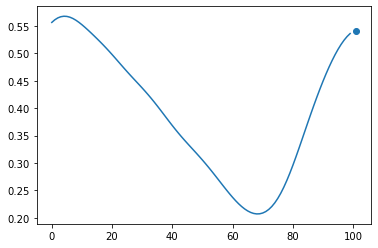

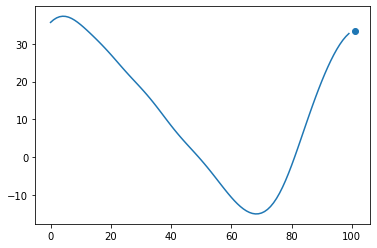

In [38]:
x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)
eg = 800
norm_X= X_val[eg,:,0].cpu().numpy()
norm_Y = Y_val[eg,:,0].cpu().numpy() 

denorm_X_all = denormalise(X_val, scalars)
denorm_Y_all = denormalise(Y_val, scalars)

denorm_X = denorm_X_all[eg,:,0]
denorm_Y = denorm_Y_all[eg,:,0]

plt.plot(x1, norm_X)
plt.scatter(x2, norm_Y)
plt.show()
plt.plot(x1, denorm_X)
plt.scatter(x2, denorm_Y)

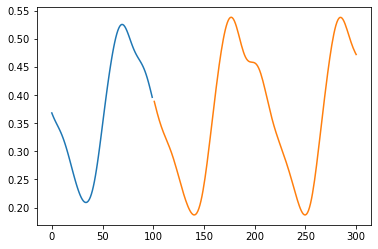

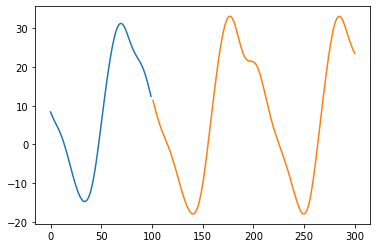

In [39]:
x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)
eg = 1000
norm_X= X_val_lt[eg,:,0].cpu().numpy()
norm_Y = Y_val_lt[eg,:,0].cpu().numpy() 

denorm_X_all = denormalise(X_val_lt, scalars)
denorm_Y_all = denormalise(Y_val_lt, scalars)

denorm_X = denorm_X_all[eg,:,0]
denorm_Y = denorm_Y_all[eg,:,0]

plt.plot(x1, norm_X)
plt.plot(x3, norm_Y)
plt.show()
plt.plot(x1, denorm_X)
plt.plot(x3, denorm_Y)

### Model training


#### Another tutorial:
https://www.kaggle.com/code/seangribben/lstm-time-series-prediction-pytorch-sine-wave

In [40]:
print(f'shape of X_train: {X_train.shape}, shape of Y_train: {Y_train.shape}')

shape of X_train: torch.Size([50020, 100, 6]), shape of Y_train: torch.Size([50020, 1, 6])


In [41]:
look_back = 100

In [42]:
# #positional encoding 
# #modified from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html 
# import math 

# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
#         super().__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         position = torch.arange(max_len).unsqueeze(1) # s: [max_len, 1]
#         div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) # s: [d_model/2]
#         pe = torch.zeros(1, max_len, d_model) # s: [max_len, 1, d_model]
#         pe[0, :, 0::2] = torch.sin(position * div_term) 
#         pe[0, :, 1::2] = torch.cos(position * div_term)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         """
#         Args:
#             x: Tensor, shape [seq_len, batch_size, embedding_dim]
        
#         """
       
#         x = x + self.pe[:,:x.size(1)] 
        
#         return x.to(DEVICE)
#         # return self.dropout(x).to(DEVICE)

In [43]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe.requires_grad = False
        #pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        #x = x + self.pe[:x.size(0), :]#Variable(self.pe[:x.size(0), :], requires_grad=False)
        x = x + self.pe[:x.size(1), :].unsqueeze(0).repeat(x.size(0), 1, 1) ## modified by Bing to adapt to batch
        return self.dropout(x)
        # return x

In [44]:
# class PositionalEncoding(nn.Module):
#     "Implement the PE function."

#     def __init__(self, d_model, dropout, max_len=100):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         # Compute the positional encodings once in log space.
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2) *
#                              -(math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe.requires_grad = False
#         #pe = pe.unsqueeze(0)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         #x = x + self.pe[:x.size(0), :]#Variable(self.pe[:x.size(0), :], requires_grad=False)
#         x = x + self.pe[:x.size(1), :].unsqueeze(0).repeat(x.size(0), 1, 1) ## modified by Bing to adapt to batch
#         # return self.dropout(x)
#         return x

In [45]:
# #source: https://github.com/QData/spacetimeformer/blob/20ab0b572b6f087964aad8d9f89a886b736bf432/spacetimeformer/time2vec.py 
# import torch
# from torch import nn

# class Time2Vec(nn.Module):
#     def __init__(self, input_dim=len(features), embed_dim=512, act_function=torch.sin):
#         assert embed_dim % input_dim == 0
#         super(Time2Vec, self).__init__()
#         self.enabled = embed_dim > 0
#         if self.enabled:
#             self.embed_dim = embed_dim // input_dim
#             self.input_dim = input_dim
#             self.embed_weight = nn.parameter.Parameter(
#                 torch.randn(self.input_dim, self.embed_dim)
#             )
#             self.embed_bias = nn.parameter.Parameter(
#                 torch.randn(self.input_dim, self.embed_dim)
#             )
#             self.act_function = act_function

#     def forward(self, x):
#         if self.enabled:
#             x = torch.diag_embed(x)
#             # x.shape = (bs, sequence_length, input_dim, input_dim)
#             x_affine = torch.matmul(x, self.embed_weight) + self.embed_bias
#             # x_affine.shape = (bs, sequence_length, input_dim, time_embed_dim)
#             x_affine_0, x_affine_remain = torch.split(
#                 x_affine, [1, self.embed_dim - 1], dim=-1
#             )
#             x_affine_remain = self.act_function(x_affine_remain)
#             x_output = torch.cat([x_affine_0, x_affine_remain], dim=-1)
#             x_output = x_output.view(x_output.size(0), x_output.size(1), -1)
#             # x_output.shape = (bs, sequence_length, input_dim * time_embed_dim)
#         else:
#             x_output = x
#         return x_output

In [46]:

# def normal_pdf(pos, mu, sigma):
#     a = pos - mu
#     log_p = -1*torch.mul(a, a)/(2*sigma) - torch.log(sigma)/2
#     return F.softmax(log_p, dim=1)


In [47]:
# class Gaussian_Position(nn.Module):
#     def __init__(self, d_model, total_size, K=10):
#         super(Gaussian_Position, self).__init__()
#         #self.embedding = get_pe(d_model, K).to('cuda')
#         #self.register_buffer('pe', self.embedding)
#         self.embedding = nn.Parameter(torch.zeros([K, d_model], dtype=torch.float), requires_grad=True)
#         nn.init.xavier_uniform_(self.embedding, gain=1)
#         self.positions = torch.tensor([i for i in range(total_size)], requires_grad=False).unsqueeze(1).repeat(1, K).to('cuda')
#         s = 0.0
#         interval = total_size / K
#         mu = []
#         for _ in range(K):
#             mu.append(nn.Parameter(torch.tensor(s, dtype=torch.float), requires_grad=True))
#             s = s + interval
#         self.mu = nn.Parameter(torch.tensor(mu, dtype=torch.float).unsqueeze(0), requires_grad=True)
#         self.sigma = nn.Parameter(torch.tensor([torch.tensor([50.0], dtype=torch.float, requires_grad=True) for _ in range(K)]).unsqueeze(0))

#     def forward(self, x):
#         M = normal_pdf(self.positions, self.mu, self.sigma)
#         pos_enc = torch.matmul(M, self.embedding)
#         #print(M)
#         return x + pos_enc.unsqueeze(0).repeat(x.size(0), 1, 1)

In [48]:
# class PositionalEmbedding(nn.Module):
#     def __init__(self, d_model, max_len=150):
#         super(PositionalEmbedding, self).__init__()
#         # Compute the positional encodings once in log space.
#         pe = torch.zeros(max_len, d_model).float()
#         pe.require_grad = False

#         position = torch.arange(0, max_len).float().unsqueeze(1)
#         div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)

#         pe = pe.unsqueeze(0)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         return self.pe[:, :x.size(1)] #returns shape of [max_len, d_model]

# class TokenEmbedding(nn.Module): 
#     def __init__(self, c_in, d_model):
#         super(TokenEmbedding, self).__init__()
#         padding = 1 if torch.__version__>='1.5.0' else 2
#         self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model, 
#                                     kernel_size=3, padding=padding, padding_mode='circular')
#         for m in self.modules():
#             if isinstance(m, nn.Conv1d):
#                 nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

#     def forward(self, x):
#         # print(f'input to token embedding: {x.shape}')
#         x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
#         # print(f'output of token embedding: {x.shape}')
#         return x #input shape: [batch_size, seq_len, len(features)] > out shape: [batch_size, seq_len, d_model]

# class FixedEmbedding(nn.Module):
#     def __init__(self, c_in, d_model):
#         super(FixedEmbedding, self).__init__()

#         w = torch.zeros(c_in, d_model).float()
#         w.require_grad = False

#         position = torch.arange(0, c_in).float().unsqueeze(1)
#         div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

#         w[:, 0::2] = torch.sin(position * div_term)
#         w[:, 1::2] = torch.cos(position * div_term)

#         self.emb = nn.Embedding(c_in, d_model)
#         self.emb.weight = nn.Parameter(w, requires_grad=False)

#     def forward(self, x):
#         return self.emb(x).detach()

# class TemporalEmbedding(nn.Module):
#     def __init__(self, d_model, embed_type='fixed', freq='h'):
#         super(TemporalEmbedding, self).__init__()

#         minute_size = 4; hour_size = 24
#         weekday_size = 7; day_size = 32; month_size = 13

#         Embed = FixedEmbedding if embed_type=='fixed' else nn.Embedding
#         if freq=='t':
#             self.minute_embed = Embed(minute_size, d_model)
#         self.hour_embed = Embed(hour_size, d_model)
#         self.weekday_embed = Embed(weekday_size, d_model)
#         self.day_embed = Embed(day_size, d_model)
#         self.month_embed = Embed(month_size, d_model)
    
#     def forward(self, x):
#         x = x.long()
        
#         minute_x = self.minute_embed(x[:,:,4]) if hasattr(self, 'minute_embed') else 0.
#         hour_x = self.hour_embed(x[:,:,3])
#         weekday_x = self.weekday_embed(x[:,:,2])
#         day_x = self.day_embed(x[:,:,1])
#         month_x = self.month_embed(x[:,:,0])
        
#         return hour_x + weekday_x + day_x + month_x + minute_x

# class TimeFeatureEmbedding(nn.Module):
#     def __init__(self, d_model, embed_type='timeF', freq='h'):
#         super(TimeFeatureEmbedding, self).__init__()

#         freq_map = {'h':4, 't':5, 's':6, 'm':1, 'a':1, 'w':2, 'd':3, 'b':3}
#         d_inp = freq_map[freq]
#         self.embed = nn.Linear(d_inp, d_model)
    
#     def forward(self, x):
#         return self.embed(x)

# class DataEmbedding(nn.Module):
#     def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
#         super(DataEmbedding, self).__init__()

#         self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
#         self.position_embedding = PositionalEmbedding(d_model=d_model)
#         self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type, freq=freq) if embed_type!='timeF' else TimeFeatureEmbedding(d_model=d_model, embed_type=embed_type, freq=freq)

#         self.dropout = nn.Dropout(p=dropout)

#     def forward(self, x,x_mark):
#         x = self.value_embedding(x) + self.position_embedding(x) + self.temporal_embedding(x_mark)
#         # x = self.value_embedding(x) + self.position_embedding(x)
        
#         return self.dropout(x)

In [49]:
# class Transformer(nn.Module):
#     def __init__(self,feature_size,num_layers,dropout=0.1):
#         super(Transformer, self).__init__()

#         # self.device = device
#         self.feature_size = feature_size
#         # self.out_seq_len = 6
#         self.d_model= 256


#         # self.t2v = Time2Vec(input_dim=len(features), embed_dim=self.d_model, act_function=torch.sin).to(DEVICE)
#         self.pe = PositionalEncoding(d_model = self.d_model).to(DEVICE)
#         # self.enc_embedding = DataEmbedding(6, 48, 'fixed', 's', 0.0)
#         # self.ge = Gaussian_Position(6,100, K=10)
#         self.encoder_input_layer = nn.Linear(
#             in_features=6, 
#             out_features=256 
#             )
#         self.transformer = nn.Transformer(d_model=self.d_model, nhead = 8, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=100, dropout=0.1, batch_first=True)
#         self.linear1 = nn.Linear(600 ,200)
#         self.linear2 = nn.Linear(200,len(features))
#         # self.sigmoid = nn.Sigmoid()


#     def forward(self,x):
#         print(f'input shape: {x.shape}')
#         src = self.encoder_input_layer(x)
#         print(f'src.shape: {src.shape}')
#         src = self.pe(src)
#         # src = self.ge(x)
#         # print(f'after embedding: {src.shape}')

#         # tgt = self.pe(x[:,:-1,:])
#         # tgt = self.pe(x[:,-1,:].unsqueeze(1))

#         # dec_in = torch.zeros((x.shape[0], x.shape[1], x.shape[2])).to(DEVICE)
#         # # print(f'zero tgt shape: {tgt.shape}')
#         # dec_in[:,:,:] = x[:,-1,:].unsqueeze(1)
#         # # print(f'after embedding: {tgt.shape}')

#         # tgt = self.pe(src)
#         out = self.transformer(src, src[:,-1,:])
#         # output of decoder shape: torch.Size([batch_size, 99, input_embed])
#         # print(f'output of transfoermer: {out.shape}')
        
#         out = out.reshape(out.shape[0], -1)
#         # print(f'reshaped transfoer out: {out.shape}')

#         out = self.linear1(out)
#         out = self.linear2(out)
     
#         out = out.reshape(x.shape[0], 1, self.feature_size)
#         # print(f'output of decoder shape: {out.shape}')

        
#         return out

In [50]:
# class Transformer(nn.Module):
#     def __init__(self,feature_size,num_layers,dropout=0.1):
#         super(Transformer, self).__init__()

#         # self.device = device
#         self.feature_size = feature_size
#         # self.out_seq_len = 6
#         self.d_model= 100


#         # self.t2v = Time2Vec(input_dim=len(features), embed_dim=self.d_model, act_function=torch.sin).to(DEVICE)
#         self.pe = PositionalEncoding(d_model = self.d_model).to(DEVICE)
#         # self.enc_embedding = DataEmbedding(6, 48, 'fixed', 's', 0.0)
#         # self.ge = Gaussian_Position(6,100, K=10)
#         self.encoder_in = nn.Linear(len(features), self.d_model)
#         self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=2, dropout=0.1, dim_feedforward=100)
#         self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=5)
#         self.linear1 = nn.Linear(10000 ,len(features))


#     def forward(self,x):
#         # print(f'input shape: {x.shape}')
#         src = self.encoder_in(x)
#         src = self.pe(src)
#         # src = self.ge(x)
#         # print(f'after embedding: {src.shape}')

#         # tgt = self.pe(x[:,:-1,:])
#         # tgt = self.pe(x[:,-1,:].unsqueeze(1))
#         # print(f'after embedding: {src.shape}')

#         out = self.transformer_encoder(src)
#         # output of decoder shape: torch.Size([batch_size, 99, input_embed])
#         # print(f'output of transfoermer: {out.shape}')
        
#         out = out.reshape(out.shape[0], -1)
#         # print(f'reshaped transfoer out: {out.shape}')

#         out = self.linear1(out)
#         # out = self.sigmoid(out)
     
#         out = out.reshape(x.shape[0], 1, self.feature_size)
#         # print(f'output of decoder shape: {out.shape}')

        
#         return out

In [51]:
# #Uncomment
# class Transformer(nn.Module):
#     def __init__(self,feature_size,num_layers,dropout=0.1):
#         super(Transformer, self).__init__()

#         # self.device = device
#         self.feature_size = feature_size
#         # self.out_seq_len = 6
#         self.d_model= len(features)


#         # self.t2v = Time2Vec(input_dim=len(features), embed_dim=self.d_model, act_function=torch.sin).to(DEVICE)
#         # self.encoder_input = nn.Linear(len(features), self.d_model)
#         self.pe = PositionalEncoding(d_model = self.d_model, dropout = 0.1).to(DEVICE)
#         # self.embed = DataEmbedding(c_in=len(features), d_model=self.d_model, dropout=0.1)
#         self.transformer = nn.Transformer(d_model=self.d_model, nhead = 6, num_encoder_layers=, num_decoder_layers=1, dim_feedforward=100, dropout=0.1, batch_first=True)
#         self.linear1 = nn.Linear(600, len(features))

#     def forward(self,x):
#         # print(f'input shape: {x.shape}')

#         # src = self.encoder_input(x)
#         src = self.pe(x)
#         # print(f'after positional encoding: {out.shape}')

#         tgt = self.pe(x[:,-1,:])
#         # tgt = self.embed(x[:,-1,:].unsqueeze(1))
#         # print(f'tgt.shape: {tgt.shape}')

#         out = self.transformer(src, tgt)
#         # output of decoder shape: torch.Size([batch_size, 99, input_embed])
#         # print(f'output of transfoermer: {out.shape}')
        
#         out = out.reshape(out.shape[0], -1)
#         # print(f'reshaped transfoer out: {out.shape}')

#         out = self.linear1(out)
#         out = out.reshape(x.shape[0], 1, self.feature_size)
#         # print(f'output of decoder shape: {out.shape}')

        
#         return out

In [52]:
# class Transformer(nn.Module):
#     def __init__(self,feature_size,num_layers,dropout=0.1):
#         super(Transformer, self).__init__()

#         # self.device = device
#         self.feature_size = feature_size
#         # self.out_seq_len = 6
#         self.d_model= 6


#         # self.t2v = Time2Vec(input_dim=len(features), embed_dim=self.d_model, act_function=torch.sin).to(DEVICE)
        
#         self.pe = PositionalEncoding(d_model = self.d_model, dropout = 0.1).to(DEVICE)
#         self.transformer = nn.Transformer(d_model=self.d_model, nhead = 6, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=100, dropout=0.1, batch_first=True)
#         self.linear = nn.Linear(600 ,len(features))
#         # self.tanh = nn.Tanh()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self,x):
#         # print(f'input shape: {x.shape}')

#         src = self.pe(x)
#         # print(f'after positional encoding: {out.shape}')

#         # tgt = self.pe(x[:,:-1,:])
#         # tgt = self.pe(x[:,-1,:].unsqueeze(1))
#         tgt = self.pe(x[:,-1,:].unsqueeze(1))

#         out = self.transformer(src, tgt)
#         # output of decoder shape: torch.Size([batch_size, 99, input_embed])
#         # print(f'output of transfoermer: {out.shape}')
        
#         out = out.reshape(out.shape[0], -1)
#         # print(f'reshaped transfoer out: {out.shape}')

#         out = self.linear(out)
#         out = self.sigmoid(out)
#         out = out.reshape(x.shape[0], 1, self.feature_size)
#         # print(f'output of decoder shape: {out.shape}')

        
#         return out

In [53]:
# class Transformer(nn.Module): 
#     def __init__(self):
#         super(Transformer, self).__init__()

#         # self.device = device
#         self.feature_size = len(features)
#         # self.out_seq_len = 6
#         self.d_model= 20


#         # self.t2v = Time2Vec(input_dim=len(features), embed_dim=self.d_model, act_function=torch.sin).to(DEVICE)
#         self.enc_in = nn.Linear(len(features), self.d_model)
#         self.dec_in = nn.Linear(len(features), self.d_model)
#         self.pe = PositionalEncoding(d_model = self.d_model, dropout = 0.2).to(DEVICE)
#         self.transformer = nn.Transformer(d_model=self.d_model, nhead = 5, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=100, dropout=0.2, batch_first=True)
#         self.linear = nn.Linear(2000 ,len(features))
#         # self.tanh = nn.Tanh()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self,x):
#         # print(f'input shape: {x.shape}')
#         src = self.enc_in(x)
#         src = self.pe(src)


#         # print(f'after positional encoding: {out.shape}')

#         # tgt = self.pe(x[:,:-1,:])
#         # tgt = self.pe(x[:,-1,:].unsqueeze(1))
#         tgt = self.dec_in(x[:,-1,:].unsqueeze(1).expand(-1,100,-1))
#         tgt = self.pe(tgt)

#         out = self.transformer(src, tgt)
#         # output of decoder shape: torch.Size([batch_size, 99, input_embed])
#         # print(f'output of transfoermer: {out.shape}')
        
#         out = out.reshape(out.shape[0], -1)
#         # print(f'reshaped transfoer out: {out.shape}')

#         out = self.linear(out)
#         out = self.sigmoid(out)
#         out = out.reshape(x.shape[0], 1, self.feature_size)
#         # print(f'output of decoder shape: {out.shape}')

        
#         return out

In [64]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()

        # self.device = device
        self.feature_size = len(features)
        # self.out_seq_len = 6
        self.d_model= 80


        # self.t2v = Time2Vec(input_dim=len(features), embed_dim=self.d_model, act_function=torch.sin).to(DEVICE)
        self.enc_in = nn.Linear(len(features), self.d_model)
        self.dec_in = nn.Linear(len(features), self.d_model)
        self.pe = PositionalEncoding(d_model = self.d_model, dropout = 0.2).to(DEVICE)
        self.transformer = nn.Transformer(d_model=self.d_model, nhead = 8, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=100, dropout=0.1, batch_first=True)
        self.linear = nn.Linear(80 ,len(features))
        # self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        print(f'input shape: {x.shape}')
        src = self.enc_in(x)
        print(f'linear layer output shape: {src.shape}')
        src = self.pe(src)


        # print(f'after positional encoding: {out.shape}')

        # tgt = self.pe(x[:,:-1,:])
        # tgt = self.pe(x[:,-1,:].unsqueeze(1))
        tgt = self.dec_in(x[:,-1,:].unsqueeze(1))
        print(f'linear layer output shape (decoder): {tgt.shape}')
        tgt = self.pe(tgt)

        out = self.transformer(src, tgt)
        # output of decoder shape: torch.Size([batch_size, 99, input_embed])
        # print(f'output of transfoermer: {out.shape}')
        
        out = out.reshape(out.shape[0], -1)
        # print(f'reshaped transfoer out: {out.shape}')

        out = self.linear(out)
        out = self.sigmoid(out)
        out = out.reshape(x.shape[0], 1, self.feature_size)
        # print(f'output of decoder shape: {out.shape}')

        
        return out

In [65]:
# class Transformer(nn.Module):
#     def __init__(self):
#         super(Transformer, self).__init__()

#         # self.device = device
#         self.feature_size = len(features)
#         # self.out_seq_len = 6
#         self.d_model= 60


#         # self.t2v = Time2Vec(input_dim=len(features), embed_dim=self.d_model, act_function=torch.sin).to(DEVICE)
#         self.encoder_input = nn.Linear(len(features), self.d_model)
#         self.pe = PositionalEncoding(d_model = self.d_model, dropout = 0.1).to(DEVICE)
#         self.transformer = nn.Transformer(d_model=self.d_model, nhead = 6, num_encoder_layers=5, num_decoder_layers=2, dim_feedforward=100, dropout=0.1, batch_first=True)
#         self.linear = nn.Linear(60 ,len(features))
#         # self.tanh = nn.Tanh()


#     def forward(self,x):
#         # print(f'input shape: {x.shape}')

#         src = self.encoder_input(x)
#         src_pe = self.pe(src)
#         # print(f'after positional encoding: {out.shape}')

#         # tgt = self.pe(x[:,:-1,:])
#         tgt = self.pe(src[:,-1,:].unsqueeze(1))

#         out = self.transformer(src_pe, tgt)
#         # output of decoder shape: torch.Size([batch_size, 99, input_embed])
#         # print(f'output of transfoermer: {out.shape}')
        
#         out = out.reshape(out.shape[0], -1)
#         # print(f'reshaped transfoer out: {out.shape}')

#         out = self.linear(out)
#         out = out.reshape(x.shape[0], 1, self.feature_size)
#         # print(f'output of decoder shape: {out.shape}')

        
#         return out

In [66]:
# class Transformer(nn.Module):
#     def __init__(self,feature_size,num_layers,dropout=0.1):
#         super(Transformer, self).__init__()

#         self.feature_size = feature_size
#         self.d_model= 30


#         self.pe = PositionalEncoding(d_model = 6, dropout=0.1).to(DEVICE)
#         self.expand_dims = nn.Linear(len(features),self.d_model)
#         self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=5, dim_feedforward=50, batch_first=True)
#         self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)       
#         self.linear1 = nn.Linear(10000, len(features))

#     def forward(self,x):
#         # print(f'input shape: {x.shape}')
#         src = self.pe(x)
#         src = self.expand_dims(src)

#         # print(f'after positional encoding: {out.shape}')

#         # tgt = self.pe(x[:,:-1,:])
#         # tgt = self.pe(x[:,-1,:].unsqueeze(1))

#         out = self.transformer_encoder(src)
#         # output of decoder shape: torch.Size([batch_size, 99, input_embed])
#         # print(f'output of transfoermer: {out.shape}')
        
#         out = out.reshape(out.shape[0], -1)
#         # print(f'reshaped transfoer out: {out.shape}')

#         out = self.linear1(out)
#         # out = self.linear2(out)
#         out = out.reshape(x.shape[0], 1, self.feature_size)
#         # print(f'output of decoder shape: {out.shape}')

        
#         return out

In [67]:
# class Transformer(nn.Module):
#     # d_model : number of features
#     def __init__(self):
#         super(Transformer, self).__init__()

#         self.num_layers=2
#         self.feature_size=6
#         self.dropout=0
#         self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.feature_size, nhead=6, dropout=self.dropout)
#         self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=self.num_layers)        
#         self.decoder = nn.Linear(self.feature_size,6)
#         self.linear = nn.Linear(600,6)
#         self.init_weights()

#     def init_weights(self):
#         initrange = 0.1    
#         self.decoder.bias.data.zero_()
#         self.decoder.weight.data.uniform_(-initrange, initrange)

#     def _generate_square_subsequent_mask(self, sz):
#         mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
#         mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
#         return mask

#     def forward(self, src):
        
#         mask = self._generate_square_subsequent_mask(len(src)).to(DEVICE)
#         output = self.transformer_encoder(src,mask)
#         output = self.decoder(output)
#         output = self.linear(output.reshape(src.shape[0], 600))
#         # print(output.shape)
#         return output.unsqueeze(1)

In [68]:
# class Transformer(nn.Module):
#     def __init__(self,feature_size,num_layers,dropout=0.1):
#         super(Transformer, self).__init__()

#         # self.device = device
#         self.feature_size = feature_size
#         # self.out_seq_len = 6
#         self.d_model= 6


#         # self.t2v = Time2Vec(input_dim=len(features), embed_dim=self.d_model, act_function=torch.sin).to(DEVICE)
#         self.pe = PositionalEncoding(d_model = self.d_model, dropout = 0.1).to(DEVICE)
#         self.transformer = nn.Transformer(d_model=self.d_model, nhead =6, num_encoder_layers=2, num_decoder_layers=3, dim_feedforward=1000, dropout=0.1, batch_first=True)
#         self.linear = nn.Linear(600 ,len(features))
#         # self.tanh = nn.Tanh()


#     def forward(self,x):
#         # print(f'input shape: {x.shape}')

#         src = self.pe(x)
#         # print(f'after positional encoding: {out.shape}')

#         tgt = self.pe(x[:,:,:])
#         out = self.transformer(src, tgt)
#         # output of decoder shape: torch.Size([batch_size, 99, input_embed])
#         # print(f'output of transfoermer: {out.shape}')
        
#         out = out.reshape(out.shape[0], -1)
#         # print(f'reshaped transfoer out: {out.shape}')

#         out = self.linear(out)
#         out = out.reshape(x.shape[0], 1, self.feature_size)
#         # print(f'output of decoder shape: {out.shape}')

        
#         return out

In [69]:
# DEVICE = 'cpu'
DEVICE = 'cuda'

In [70]:
fname = 'Exp082_221124_Transformer'
folder_path = r'D:\Study 2 Results and Models\Study 2 Experiments' + '\\' + fname 
path = r'D:\Study 2 Results and Models\Study 2 Experiments'+ '\\' + fname + '\\'  + fname + '.pth'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
else:
    print('File already exists, choose a different name')
    raise 
    


File already exists, choose a different name


RuntimeError: No active exception to reraise

In [71]:
len(val_lt_dataloader)

6

In [72]:
# class Transformer(nn.Module):
#     # d_model : number of features
#     def __init__(self,feature_size=6,num_layers=1,dropout=0):
#         super(Transformer, self).__init__()

#         self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=6, dropout=dropout)
#         self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
#         self.decoder = nn.Linear(feature_size,6)
#         self.init_weights()

#     def init_weights(self):
#         initrange = 0.1    
#         self.decoder.bias.data.zero_()
#         self.decoder.weight.data.uniform_(-initrange, initrange)

#     def _generate_square_subsequent_mask(self, sz):
#         mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
#         mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
#         return mask

#     def forward(self, src):
        
#         mask = self._generate_square_subsequent_mask(len(src)).to(DEVICE)
#         output = self.transformer_encoder(src,mask)
#         output = self.decoder(output[:,-1,:]).unsqueeze(1)
#         # print(f'outshape:{output.shape}')
#         return output

In [73]:
# model = LSTM(n_neurons, look_back).double().to(DEVICE)
# model = Transformer(feature_size=len(features),num_layers=1,dropout=0.1).double().to(DEVICE)
model = Transformer().double().to(DEVICE)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss = []
val_loss = []
lt_loss = []
dtw_loss = []

lowest_dtw = 1000.

for epoch in tqdm(range(100)):
    train_loss_total = 0.
    i = 0
    model.train()
    for idx, (batch_inputs, batch_targets) in enumerate(train_dataloader):
        i += 1
        model.zero_grad()
        # print(f'train_labels shape: {batch_inputs.shape}')

        batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
        
        # print(f'batch_inputs.shape {batch_inputs.shape}')
        predictions = model(batch_inputs)
        # print(f'predictions.shape {predictions.shape}')
        # print(f'train_labels shape: {batch_targets.shape}')
        loss = loss_function(predictions, batch_targets)

        train_loss_total += loss.item()
        loss.backward()
        optimizer.step()
    # print(f'len(dataloader): {len(train_dataloader)}')
    train_loss_total = train_loss_total/len(train_dataloader)
    train_loss.append(train_loss_total)

    # Calculate validation loss
    model.eval()
    with torch.no_grad():
        val_loss_total = 0.
        for idx, (batch_inputs, batch_targets) in enumerate(val_dataloader):
            

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
            predictions = model(batch_inputs)
            # print(f'train_labels shape: {train_labels.shape}')
            loss = loss_function(predictions, batch_targets)
            val_loss_total += loss.item()
    
    val_loss_total = val_loss_total/len(val_dataloader)
    val_loss.append(val_loss_total)

    # Calculating long term loss
    model.eval()
    with torch.no_grad():
        lt_loss_total = 0.
        dtw_total = 0.

        for idx, (batch_inputs, batch_targets) in enumerate(val_lt_dataloader):

            extrapolation = torch.zeros((batch_inputs.shape[0], 200, len(features))).to(DEVICE)
            # print(f'extrapolation.shape: {extrapolation.shape}')

            batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
            current_inputs = batch_inputs
            for i in range(200):
                # print(f'current_inputs.shape {current_inputs.shape}')
                predictions = model(current_inputs)
                # print(f'predictions.shape {predictions.shape}')

                extrapolation[:,i,:] = predictions.squeeze(1)
                # print(f'current_inputs[:,1:,:].shape {current_inputs[:,1:,:].shape}')
                # print(f'predictions.shape {predictions.shape}')

                #concat shape [batch_size, 99, len(features)] and [batch_size, 1, len(features)]
                current_inputs = torch.cat((current_inputs[:,1:,:], predictions), axis=1)

            loss = loss_function(extrapolation, batch_targets)
    
            lt_loss_total += loss.item()

            #dtw
            running_dtw = 0.
            for s in range(batch_targets.shape[0]):
                for f in range(len(features)):
                    dis = dtw(extrapolation[s,:,f].squeeze().cpu(),batch_targets[s,:,f].squeeze().cpu(), distance_only=True).distance
                    
                    running_dtw += dis

            dtw_total += running_dtw / (batch_targets.shape[0] * len(features))

    lt_loss_total = lt_loss_total/len(val_lt_dataloader)
    lt_loss.append(lt_loss_total)

    dtw_total = dtw_total / (len(val_lt_dataloader))
    dtw_loss.append(dtw_total)

    # plot one sample of extraplation 

    if epoch % 5 == 0:
        x1 = np.arange(0,100)
        x3 = np.arange(101,301)

        fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
        n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

        text_size = 11
        for f in range(len(features)):
            axs[n[f][0],n[f][1]].plot(x1, batch_inputs[0,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label='input')
            axs[n[f][0],n[f][1]].plot(x3, extrapolation[0,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='g', linestyle='dashed',label='extrapolation')
            axs[n[f][0],n[f][1]].plot(x3, batch_targets[0,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
            axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
            axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
            axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)
        
        plt.legend()

        plt.show()

        
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss_total}, Val Loss: {val_loss_total}, lt Loss: {lt_loss_total}, dtw distance: {dtw_total}')


    if dtw_total < lowest_dtw:
        print('New model saved!')
        lowest_dtw = dtw_total
        
        checkpoint = {'model': model,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, path)


        

  0%|          | 0/100 [00:00<?, ?it/s]

input shape: torch.Size([512, 100, 6])
linear layer output shape: torch.Size([512, 100, 80])
linear layer output shape (decoder): torch.Size([512, 1, 80])
input shape: torch.Size([512, 100, 6])
linear layer output shape: torch.Size([512, 100, 80])
linear layer output shape (decoder): torch.Size([512, 1, 80])
input shape: torch.Size([512, 100, 6])
linear layer output shape: torch.Size([512, 100, 80])
linear layer output shape (decoder): torch.Size([512, 1, 80])
input shape: torch.Size([512, 100, 6])
linear layer output shape: torch.Size([512, 100, 80])
linear layer output shape (decoder): torch.Size([512, 1, 80])


KeyboardInterrupt: 

In [121]:
#load model 
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint(path)

In [122]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# print()

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

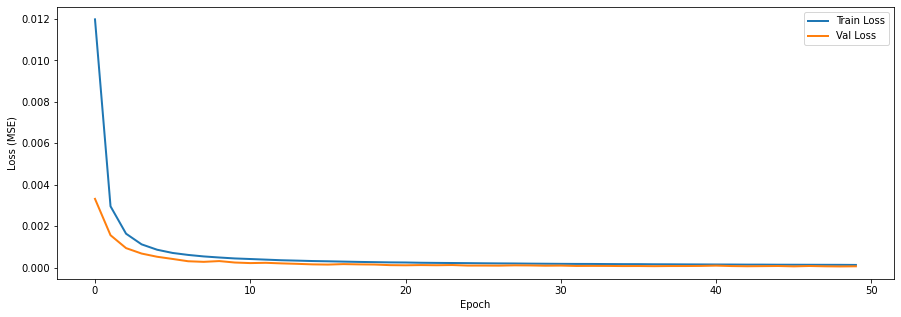

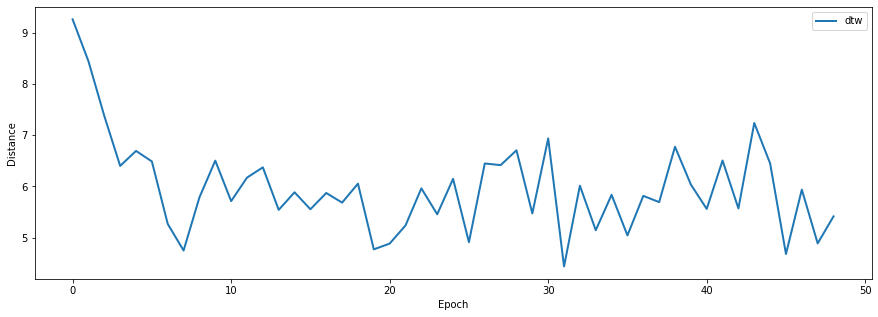

In [123]:

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

plt.figure(1)
ax.plot(train_loss[:], lw=2, label='Train Loss')
ax.plot(val_loss[:], lw=2, label='Val Loss')
# ax.plot(lt_loss[:], lw=2, label='Long term prediction Loss')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
ax.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(dtw_loss, lw=2, label='dtw')
plt.xlabel("Epoch")
plt.ylabel("Distance")
plt.legend()
plt.show()

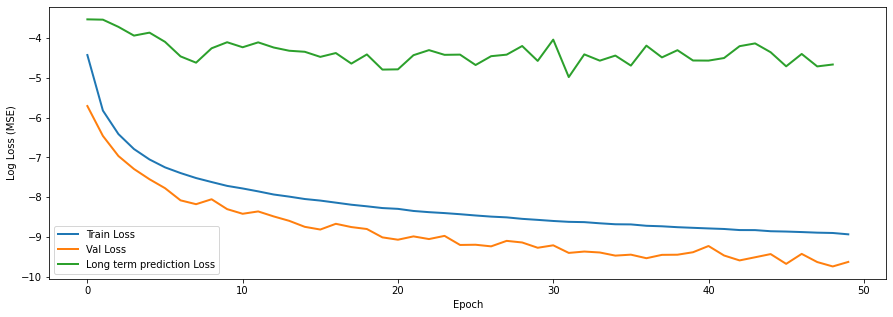

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.plot(np.log(train_loss[:]), lw=2, label='Train Loss')
ax.plot(np.log(val_loss[:]), lw=2, label='Val Loss')
ax.plot(np.log(lt_loss[:]), lw=2, label='Long term prediction Loss')

ax.set_xlabel("Epoch")
ax.set_ylabel("Log Loss (MSE)")
ax.legend()
plt.show()

In [125]:
val_lt_dataset = X_val_lt[:10,:,:].to(DEVICE)
model.eval()
with torch.no_grad():
    val_lt_predictions = model(val_lt_dataset)

val_lt_predictions.shape

torch.Size([10, 1, 6])

In [126]:
#Single Joint Plot
# x1 = np.arange(0,100)
# x2 = 101
# s = 200

# fig, ax = plt.subplots(1,1,figsize=(15,5))

# plt.plot(x1, test_dataset[s,:,0].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label = 'input')
# plt.scatter(x2, test_predictions[s,:,0].cpu().numpy(), lw=6, c='g', label='prediction')

# plt.xlabel('Time-steps')
# plt.ylabel('Angle (normalised)')
# ax.legend(loc='lower left')
# plt.show()

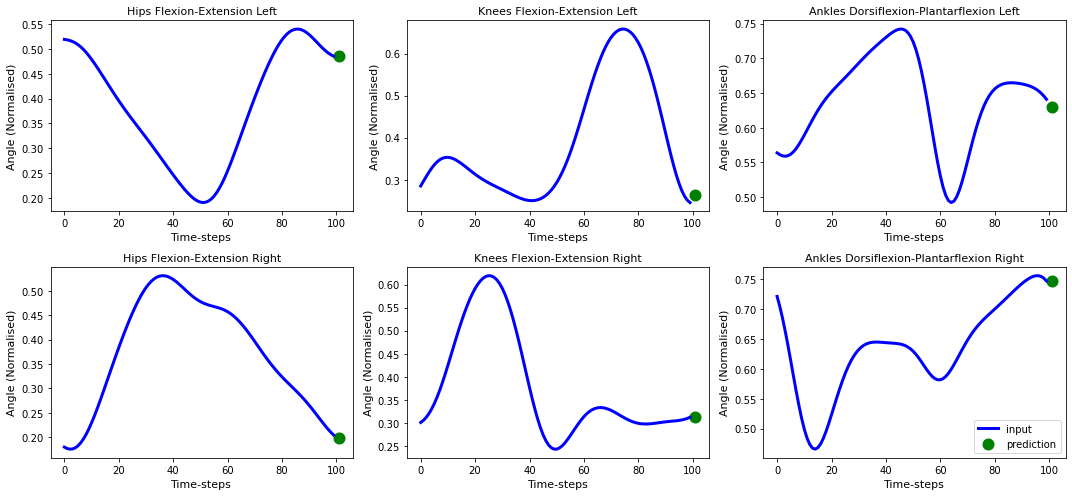

In [127]:
x1 = np.arange(0,100)
x2 = 101
s = 2

fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

text_size = 11

for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, val_lt_dataset[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label = 'input')
    axs[n[f][0],n[f][1]].scatter(x2, val_lt_predictions[s,:,f].cpu().numpy(), lw=6, c='g', label='prediction')
    axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

# axLine, axLabel = ax.get_legend_handles_labels()
plt.legend()

In [128]:
extrapolation_lt = torch.zeros((1,200, len(features))).to(DEVICE)
sample_lt = X_val_lt[s,:,:].unsqueeze(0).to(DEVICE)
current_batch = sample_lt

model.eval()
with torch.no_grad():
    for i in range(200):
        predicted_value = model(current_batch)
        extrapolation_lt[:,i,:] = predicted_value
        current_batch = torch.cat((current_batch[:,1:,:], predicted_value), axis=1)

sample_lt.shape

torch.Size([1, 100, 6])

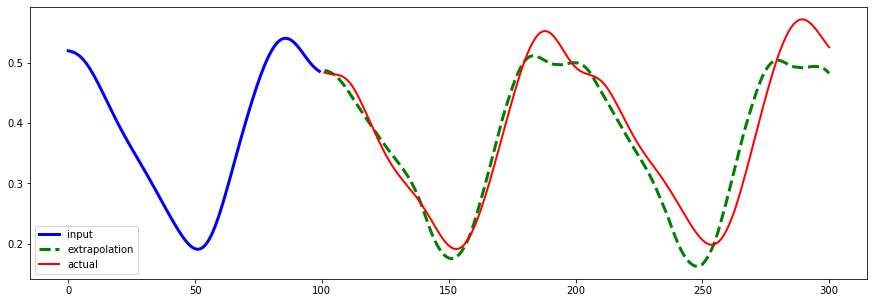

In [129]:
x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)

fig, ax = plt.subplots(1,1,figsize=(15,5))
plt.plot(x1, sample_lt[:,:,0].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label='input')
plt.plot(x3, extrapolation_lt[:,:,0].cpu().numpy().reshape(-1,1).squeeze(), lw=3, linestyle='dashed', c='g', label='extrapolation')
plt.plot(x3, Y_val_lt[s,:,0].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
plt.legend()

sample: 2


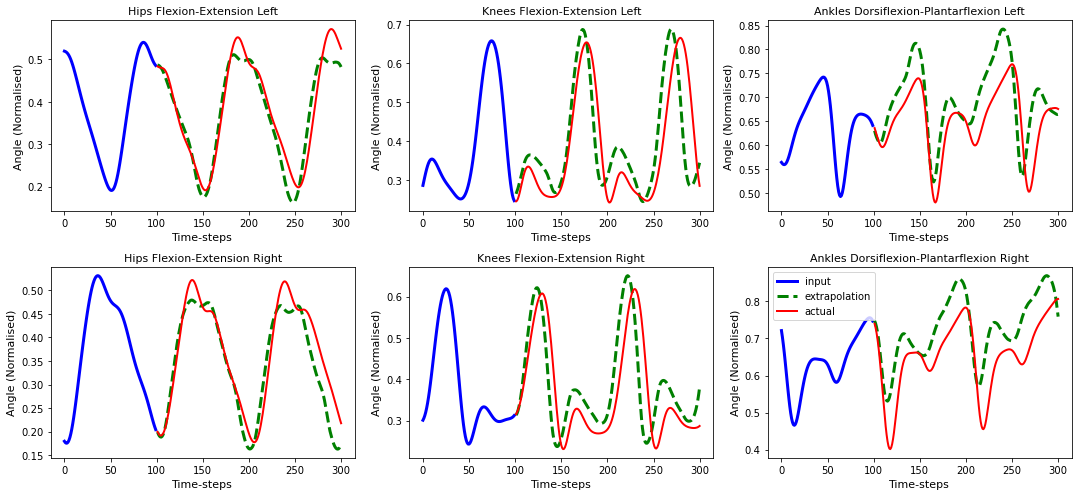

In [130]:
x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)

fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

text_size = 11
for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, sample_lt[:,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label='input')
    axs[n[f][0],n[f][1]].plot(x3, extrapolation_lt[:,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, linestyle='dashed', c='g', label='extrapolation')
    axs[n[f][0],n[f][1]].plot(x3, Y_val_lt[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
    axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

plt.legend()
           
print(f'sample: {s}')

In [131]:
#plot denormalised 

input = denormalise(sample_lt.cpu().numpy(), scalars)
lt_preds = denormalise(extrapolation_lt.cpu().numpy(), scalars)
actual = denormalise(Y_val_lt.cpu().numpy(), scalars)
one_pred = denormalise(lt_preds[:,0,:].reshape((lt_preds.shape[0],1,6)), scalars)


sample: 2


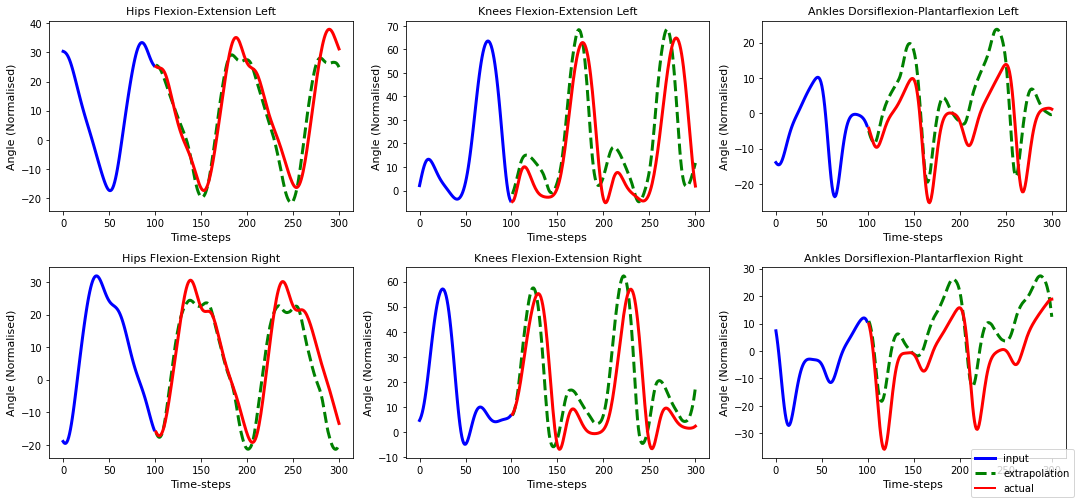

In [132]:
x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)

fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

text_size = 11
for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, input[:,:,f].reshape(-1,1).squeeze(), lw=3, c='b', label='input')
    axs[n[f][0],n[f][1]].plot(x3, lt_preds[:,:,f].reshape(-1,1).squeeze(), lw=3, linestyle='dashed', c='g', label='extrapolation')
    axs[n[f][0],n[f][1]].plot(x3, actual[s,:,f].reshape(-1,1).squeeze(), lw=3, c='r', label='actual')
    # axs[n[f][0],n[f][1]].scatter(x2, one_pred[s,:,f].reshape(-1,1).squeeze(), lw=3, c='r', label='single prediction')
    axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

axLine, axLabel = ax.get_legend_handles_labels()
fig.legend(axLine, axLabel,           
           loc = 'lower right')
           
print(f'sample: {s}')

In [133]:
from dtw import *

# plt.plot(lt_preds[:,:,0].squeeze())
# plt.plot(actual[s,:,0].squeeze())
sum = 0.
for f in range(len(features)):
    curve1= lt_preds[:,:,f].squeeze()
    curve2= actual[s,:,f].squeeze()
    path = dtw(curve1,curve2, dist_method='euclidean', keep_internals=True)

    # path.plot(type="threeway")

    # dtw(curve1, curve2, keep_internals=True, 
    #     step_pattern=rabinerJuangStepPattern(6, "c"))\
    #     .plot(type="twoway",offset=-2)

    print(f'distance for {features[f]}: {path.distance:.4f}')
    sum+=path.distance 


distance for Hips Flexion-Extension Left: 440.7178
distance for Knees Flexion-Extension Left: 584.3734
distance for Ankles Dorsiflexion-Plantarflexion Left: 603.3281
distance for Hips Flexion-Extension Right: 367.7752
distance for Knees Flexion-Extension Right: 681.1459
distance for Ankles Dorsiflexion-Plantarflexion Right: 960.2455


In [134]:
# from dtw import *

# # plt.plot(lt_preds[:,:,0].squeeze())
# # plt.plot(actual[s,:,0].squeeze())
# sum = 0.
# for f in range(len(features)):
#     curve1= lt_preds[:,:,:].squeeze()
#     curve2= actual[s,:,:].squeeze()
#     path = dtw(curve1,curve2, dist_method='euclidean', keep_internals=True)

#     path.plot(type="threeway")

#     dtw(curve1, curve2, keep_internals=True, 
#         step_pattern=rabinerJuangStepPattern(6, "c"))\
#         .plot(type="twoway",offset=-2)

#     print(f'distance for {features[f]}: {path.distance:.4f}')
#     sum+=path.distance


### Calculating MSE and MAE

In [135]:
print(f'shape of X validation data: {X_val.shape}, Y validation data: {Y_val.shape}')

shape of X validation data: torch.Size([5732, 100, 6]), Y validation data: torch.Size([5732, 1, 6])


In [136]:
model.eval()
total_mse = 0.
total_mse_std=0.
total_mae=0. 
total_mae_std=0.
i = 0
with torch.no_grad():
    for idx, (batch_inputs,batch_targets) in enumerate(val_dataloader):
        batch_inputs, batch_targets = batch_inputs.to(DEVICE), batch_targets.to(DEVICE)
        val_predictions = model(batch_inputs)

        
        input_val = denormalise(batch_inputs.cpu().numpy(), scalars)
        actual_val = denormalise(batch_targets[:,:,:].cpu().numpy(), scalars)
        preds_val = denormalise(val_predictions.cpu().numpy(), scalars)

        val_mse_loss, val_mse_std = mse_loss(preds_val, actual_val, reduction='mean', format='np')
        val_mae_loss, val_mae_std = mae_loss(preds_val, actual_val, reduction='mean', format='np')

        print(f'Val MSE Loss: {val_mse_loss:.5}, Val MSE std: {val_mse_std:.5}')
        print(f'Val MAE Loss: {val_mae_loss:.5}, Val MAE std: {val_mae_std:.5}')

        total_mse += val_mse_loss
        total_mse_std += val_mse_std 
        total_mae += val_mae_loss
        total_mae_std += val_mae_std
        i += 1

total_mse = total_mse/i
total_mse_std = total_mse_std/i 
total_mae = total_mae/i
total_mae_std = total_mae_std/i

print('totals:')
print(f'Val MSE Loss: {total_mse:.5}, Val MSE std: {total_mse_std:.5}')
print(f'Val MAE Loss: {total_mae:.5}, Val MAE std: {total_mae_std:.5}')

Val MSE Loss: 1.8447, Val MSE std: 3.0477
Val MAE Loss: 1.0563, Val MAE std: 0.85382
Val MSE Loss: 1.9009, Val MSE std: 3.1128
Val MAE Loss: 1.0756, Val MAE std: 0.86258
Val MSE Loss: 1.8707, Val MSE std: 3.097
Val MAE Loss: 1.0606, Val MAE std: 0.86363
Val MSE Loss: 1.9186, Val MSE std: 3.2194
Val MAE Loss: 1.0644, Val MAE std: 0.8863
Val MSE Loss: 1.8401, Val MSE std: 3.0889
Val MAE Loss: 1.0529, Val MAE std: 0.85534
Val MSE Loss: 1.8978, Val MSE std: 3.2208
Val MAE Loss: 1.0688, Val MAE std: 0.86918
Val MSE Loss: 1.8516, Val MSE std: 3.195
Val MAE Loss: 1.0504, Val MAE std: 0.86497
Val MSE Loss: 1.9144, Val MSE std: 3.1928
Val MAE Loss: 1.0669, Val MAE std: 0.88102
Val MSE Loss: 1.9545, Val MSE std: 3.3127
Val MAE Loss: 1.0751, Val MAE std: 0.89362
Val MSE Loss: 1.8653, Val MSE std: 3.1232
Val MAE Loss: 1.053, Val MAE std: 0.86983
Val MSE Loss: 1.9377, Val MSE std: 3.3764
Val MAE Loss: 1.0776, Val MAE std: 0.88117
Val MSE Loss: 1.8303, Val MSE std: 3.0531
Val MAE Loss: 1.0321, Val M

In [137]:
# Calculate predictions
val_dataset = X_val[:, :, :].to(DEVICE)

model.eval()
with torch.no_grad():
    val_predictions = model(val_dataset)

#Denormalise X_val and Y_val and predictions 
# input_val = denormalise(X_val.cpu().numpy(), scalars)
# actual_val = denormalise(Y_val.cpu().numpy(), scalars)
# preds_val = denormalise(test_predictions.cpu().numpy(), scalars)


input_val = denormalise(X_val.cpu().numpy(), scalars)
actual_val = denormalise(Y_val[:,:,:].cpu().numpy(), scalars)
preds_val = denormalise(val_predictions.cpu().numpy(), scalars)

RuntimeError: CUDA out of memory. Tried to allocate 3.42 GiB (GPU 0; 8.00 GiB total capacity; 5.16 GiB already allocated; 1021.99 MiB free; 5.19 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
diff = abs(Y_val[:,:,0].to(DEVICE) - val_predictions[:,:,0])
print(diff.shape)
plt.hist(diff.cpu().numpy().reshape(-1,1).squeeze(), 60)
plt.title('Histogram of Errors')
plt.show()


In [ ]:
threshold = 0.02
larger_than_mean = np.where(diff.unsqueeze(-1).cpu().numpy()>threshold) #np where returns index

print(f'number of samples above threshold: {len(larger_than_mean[0])}')
print(f'e.g. of sample number {larger_than_mean[0][10]}')

In [ ]:
#plot values larger than threshold
x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)
l_error = larger_than_mean[0][2]

fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

text_size = 11
for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, X_val[l_error,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label='input')
    axs[n[f][0],n[f][1]].scatter(x2, val_predictions[l_error,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, linestyle='dashed', c='g', label='prediction')
    axs[n[f][0],n[f][1]].scatter(x2, Y_val[l_error,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
    axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)
    

plt.legend()
           
print(f'sample: {s}')

In [ ]:
# mse = np.mean((actual_val-preds_val) ** 2)
# mae = np.mean(np.abs(actual_val-preds_val))

val_mse_loss, val_mse_std = mse_loss(preds_val, actual_val, reduction='mean', format='np')
val_mae_loss, val_mae_std = mae_loss(preds_val, actual_val, reduction='mean', format='np')

print(f'Val MSE Loss: {val_mse_loss:.5}, Val MSE std: {val_mse_std:.5}')
print(f'Val MAE Loss: {val_mae_loss:.5}, Val MAE std: {val_mae_std:.5}')


In [ ]:
for f in range(len(features)):
    print(f' error for {features[f]} is: {np.mean(abs(preds_val[:,:,f]-actual_val[:,:,f])):.3f}')

In [ ]:
diff = abs(preds_val[:,:,:] -actual_val[:,:,:])
plt.hist(diff.squeeze(), 60)
plt.xlabel('Error between actual and predictions (degrees)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
threshold = 2
larger_than_mean = np.where(diff>threshold) #np where returns index

print(f'number of samples above threshold: {len(larger_than_mean[0])}')
print(f'e.g. of sample number {larger_than_mean[0][1]}')

In [ ]:
#plot values larger than threshold
x1 = np.arange(0,100)
x2 = 101
x3 = np.arange(101,301)
l_error = larger_than_mean[0][1]

fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

text_size = 11
for f in range(len(features)):
    axs[n[f][0],n[f][1]].plot(x1, input_val[l_error,:,f].reshape(-1,1).squeeze(), lw=3, c='b', label='input')
    axs[n[f][0],n[f][1]].scatter(x2, preds_val[l_error,:,f].reshape(-1,1).squeeze(), lw=3, linestyle='dashed', c='g', label='prediction')
    axs[n[f][0],n[f][1]].scatter(x2, actual_val[l_error,:,f].reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
    axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
    axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
    axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

plt.legend()
           
print(f'sample: {s}')

In [ ]:
x1 = np.arange(0,100)
x2 = 101
s = 10
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

plt.plot(x1, input_val[s,:,0].reshape(-1,1).squeeze(), lw=3, c='b', label='input')
plt.scatter(x2, actual_val[s,:,0], lw=4, c='r', label='actual')
plt.scatter(x2, preds_val[s,:,0], lw=4, c='g', label='prediction')

plt.xlabel('Time-step')
plt.ylabel('Angle (degrees)')

ax.legend(loc="lower left")
plt.show()

In [ ]:
# x1 = np.arange(0,100)
# x2 = 101
# x3 = np.arange(101,301)
# s = 1200
# fig, axs = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(15,7))
# n = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]] #indicies for the plots

# text_size = 11
# for f in range(len(features)):
#     axs[n[f][0],n[f][1]].plot(x1, X_val_lt[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, c='b', label='input')
#     axs[n[f][0],n[f][1]].plot(x3, extrapolation_lt[:,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=3, linestyle='dashed', c='g', label='extrapolation')
#     axs[n[f][0],n[f][1]].plot(x3, Y_val_lt[s,:,f].cpu().numpy().reshape(-1,1).squeeze(), lw=2, c='r', label='actual')
#     axs[n[f][0],n[f][1]].set_xlabel('Time-steps', size=text_size)
#     axs[n[f][0],n[f][1]].set_ylabel('Angle (Normalised)', size=text_size)
#     axs[n[f][0],n[f][1]].set_title(features[f], size=text_size)

# plt.legend()
           
# print(f'sample: {s}')

### Model shape

In [138]:
model.eval()

Transformer(
  (enc_in): Linear(in_features=6, out_features=80, bias=True)
  (dec_in): Linear(in_features=6, out_features=80, bias=True)
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=80, out_features=80, bias=True)
          )
          (linear1): Linear(in_features=80, out_features=100, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=100, out_features=80, bias=True)
          (norm1): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((80,), eps=1e

### Export Model


In [139]:
# fname = 'Exp015_220905_Transformer'
# path = r'D:\Study 2 Results and Models\Study 2 Experiments'+ '\\' + fname + '\\'  + fname + '.pth'

# checkpoint = {'model': model,
#           'state_dict': model.state_dict(),
#           'optimizer' : optimizer.state_dict()}

# torch.save(checkpoint, path)

In [140]:
## benchmark against naive output (making prediction only last value)
naive_1_train_output = np.zeros(actual_val.shape)

    
for f in range(len(features)):
    for s in range(actual_val.shape[0]):
        naive_1_train_output[s,:,f] = np.ones((output_window)) * input_val[s,-1,f]

In [141]:
naive_1_mse_loss, naive_1_mse_std = mse_loss(naive_1_train_output, actual_val, reduction='mean', format='np')
naive_1_mae_loss, naive_1_mae_std = mae_loss(naive_1_train_output, actual_val, reduction='mean', format='np')

print(f'naive_1 MSE Loss: {naive_1_mse_loss}')
print(f'naive_1 MSE std: {naive_1_mse_std} ')
print(f'naive_1 MAE Loss: {naive_1_mae_loss}')
print(f'naive_1 MAE std: {naive_1_mae_std}')

naive_1 MSE Loss: 2.190147923625479
naive_1 MSE std: 3.7065860768588914 
naive_1 MAE Loss: 1.1011103541652363
naive_1 MAE std: 0.988789113803134
